In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import geopandas as gpd


pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100


import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib import rc


import plotly.express as px

from paths import *
from scripts import vis_simulaCovid

import yaml


## SimulaCovid API ('http://datasource.coronacidades.org:7000/')
- br/states/rt
- br/cities/embaixadores
- br/cities/cnes
- world/owid/heatmap
- br/cities/farolcovid/main
- br/cities/rt
- br/cities/simulacovid/main
- br/cities/cases/full
- br/states/farolcovid/main


### RT

In [2]:
#load br cities
geo_sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
# cols = ['geocodigo','nome_mesorregiao','geometry']
cols = ['geocodigo','nome_mesorregiao','nome_municipio']
geo_sp = geo_sp[cols]

In [3]:
#load state data
url  = 'http://datasource.coronacidades.org/'
data = 'br/states/rt'

ds = pd.read_csv(f'{url}{data}')

ds['last_updated'] = pd.to_datetime(ds['last_updated'])

sp = ds[ds['state']=='SP']
sp = sp.rename(columns={'state':'city_id'})
sp['nome_mesorregiao'] = 'SP'
sp['nome_municipio']   = 'Estado de SP'

rj = ds[ds['state']=='RJ']
rj = rj.rename(columns={'state':'city_id'})
rj['nome_mesorregiao'] = 'RJ'
rj['nome_municipio']   = 'Estado do RJ'

mg = ds[ds['state']=='MG']
mg = mg.rename(columns={'state':'city_id'})
mg['nome_mesorregiao'] = 'MG'
mg['nome_municipio']   = 'Estado de MG'

am = ds[ds['state']=='AM']
am = am.rename(columns={'state':'city_id'})
am['nome_mesorregiao'] = 'AM'
am['nome_municipio']   = 'Estado de AM'

In [15]:
#load cities data
data = 'br/cities/rt'

df = pd.read_csv(f'{url}{data}')

df['last_updated'] = pd.to_datetime(df['last_updated'])


dd = df.merge(geo_sp, how='right', left_on = 'city_id', right_on = 'geocodigo')
dd.head()

regiao = 'Vale do Paraíba Paulista'
mask = (dd['nome_mesorregiao']==regiao)
vale = dd[mask]
vale = vale[vale['city_id'].notnull()]

mask = (dd['nome_municipio']=='São Paulo')
sp_city = dd[mask]


vale = pd.concat([vale,sp_city], 0)
vale = pd.concat([vale,sp], 0)
vale = pd.concat([vale,rj], 0)
vale = pd.concat([vale,mg], 0)
# vale = pd.concat([vale,am], 0)



In [16]:
def plot_rt_final(df_final,col,N_COLS):
    
    N_ROWS = int(np.ceil(len(df_final[col].unique()) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=400)

    for i, (city, result) in enumerate(df_final.groupby(col,sort=False)):
        ax = axes.flat[i]
        vis_simulaCovid.plot_rt(result, ax, city)
    fig.tight_layout()
    fig.set_facecolor('w')
    
    return fig

In [17]:
len(vale['nome_municipio'].unique())

36

In [27]:
vale.sort_values(by='last_updated', ascending=False).head()

city_id last_updated  Rt_most_likely  Rt_low_95  Rt_high_95  \
891             MG   2020-06-24            1.17       1.11        1.21   
9957    3.5204e+06   2020-06-24            1.21       0.90        1.47   
15553   3.5317e+06   2020-06-24            1.56       0.58        2.60   
2201   3.50491e+06   2020-06-24            1.26       0.57        1.96   
13228  3.52660e+06   2020-06-24            1.20       0.66        1.69   

       data_last_refreshed  geocodigo          nome_mesorregiao  \
891    2020-06-25 00:09:58        NaN                        MG   
9957   2020-06-25 01:04:42  3520400.0  Vale do Paraíba Paulista   
15553  2020-06-25 01:04:42  3531704.0  Vale do Paraíba Paulista   
2201   2020-06-25 01:04:42  3504909.0  Vale do Paraíba Paulista   
13228  2020-06-25 01:04:42  3526605.0  Vale do Paraíba Paulista   

        nome_municipio  
891       Estado de MG  
9957          Ilhabela  
15553  Monteiro Lobato  
2201           Bananal  
13228        Lavrinhas

In [19]:
fig = plot_rt_final(ds,'state',3)
fig.savefig("/home/m/Downloads/Evolucao da Taxa de Transmissão Efetiva - Estados.pdf.pdf", bbox_inches='tight')

In [20]:
last_date = max(vale['last_updated']).strftime('%d-%m-%Y')

fig = plot_rt_final(vale,'nome_municipio',4)

fig.savefig(f"/home/m/Downloads/Evolucao da Taxa de Transmissão Efetiva - Vale do Paraíba e Litoral Norte.pdf", bbox_inches='tight')

## Selected cities

In [21]:
## Rt for most recent date
max_date = max(vale['last_updated'])
vale_last_date = vale.drop_duplicates('nome_municipio', keep='last').sort_values(by='Rt_most_likely')
last_date = max_date.strftime('%Y-%m-%d')
fig = vis_simulaCovid.plot_rt_bars(vale_last_date, title= f'Taxa Transmissão Efetiva em {last_date}', place_type='nome_municipio')

In [22]:
fig = fig.update_xaxes(tickangle=30)
fig.write_image(f"/home/m/Downloads/Taxa Transmissão Efetiva em {last_date}.pdf", width=1080, height=720)

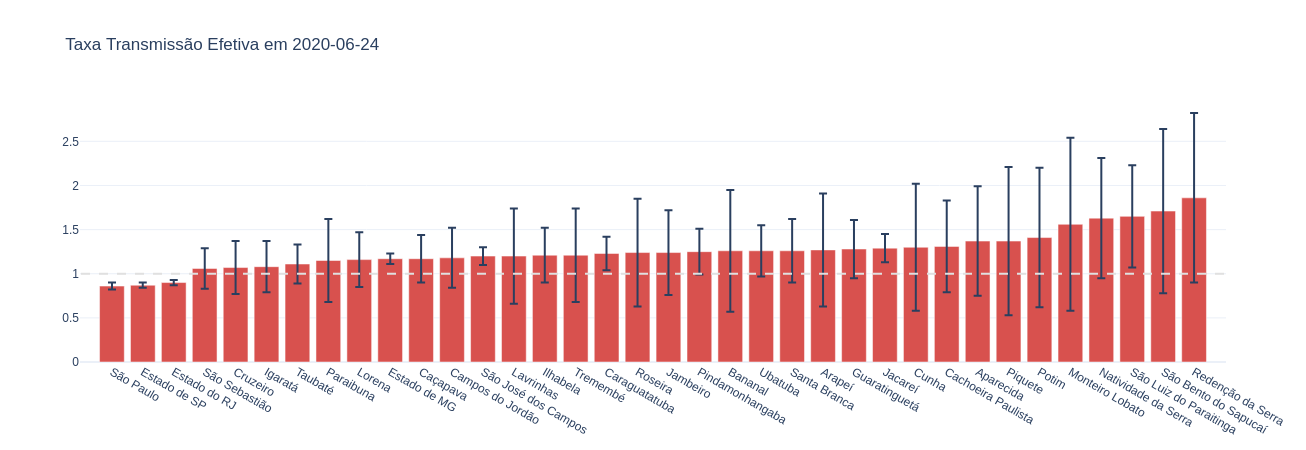

In [23]:
fig

In [24]:
vale_last_date['nome_municipio']

23167                 São Paulo
2137               Estado de SP
1553               Estado do RJ
23362             São Sebastião
6521                   Cruzeiro
9812                    Igaratá
25051                   Taubaté
16968                 Paraibuna
13630                    Lorena
891                Estado de MG
4098                   Caçapava
4878           Campos do Jordão
22832       São José dos Campos
13228                 Lavrinhas
9957                   Ilhabela
25312                  Tremembé
5284              Caraguatatuba
20352                   Roseira
12459                  Jambeiro
17867           Pindamonhangaba
2201                    Bananal
25638                   Ubatuba
20902              Santa Branca
1357                     Arapeí
8888              Guaratinguetá
12205                   Jacareí
6647                      Cunha
4184         Cachoeira Paulista
1067                  Aparecida
18012                   Piquete
19010                     Potim
15553   

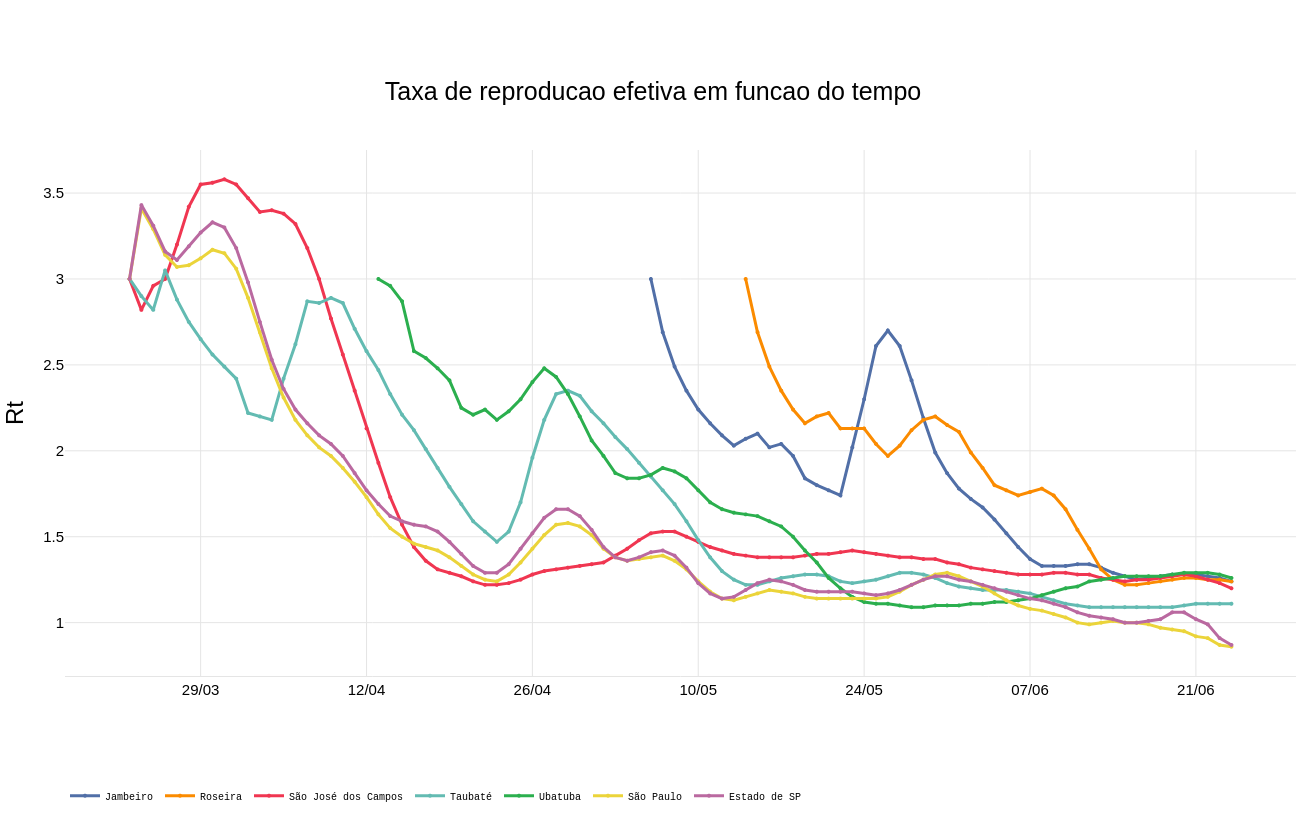

In [25]:
municipios = ['São Paulo', 'Estado de SP', 'Taubaté', 'São José dos Campos', 'Jambeiro','Roseira','Ubatuba']
vale_filtered = vale[vale['nome_municipio'].isin(municipios)]



themes = yaml.load(open('../themes/themes_simulaCovid.yaml', 'r'), Loader=yaml.FullLoader)
themes = themes['rt_selected_cities']
fig = vis_simulaCovid.plot_rt_plotly(vale_filtered, themes)

fig

## RT MAP

In [ ]:
#load br cities
sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
cols = ['geocodigo','nome_mesorregiao','geometry']
sp = sp[cols]

In [ ]:
#load data
url  = 'http://datasource.coronacidades.org:7000/'
data = 'br/cities/farolcovid/main'

df = pd.read_csv(f'{url}{data}')

dd = df.merge(sp, how='right', left_on = 'city_id', right_on = 'geocodigo')
dd = gpd.GeoDataFrame(dd)


regiao = 'Vale do Paraíba Paulista'
mask = dd['nome_mesorregiao']==regiao
vale = dd[mask]

vale = gpd.GeoDataFrame(vale)

In [116]:
def plot_map(dd,var):
    fig = plt.figure(figsize=(25,25))
    ax  = fig.add_subplot(1,1,1)
    ax.set_title(f'{var}', fontsize=23)


    missings={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    }


    # dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[0.75,1]},missing_kwds=missings )
#     dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[10,100,500,1000,10000]},missing_kwds=missings )
#     dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[1,5,10,50,100,500,1000,3000]},missing_kwds=missings )
    dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[10,30,50,70]},missing_kwds=missings )

#     dd.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" ,missing_kwds=missings, scheme='quantiles',k=30)

    ax.axis('off')


    plt.rc('legend',fontsize='large')

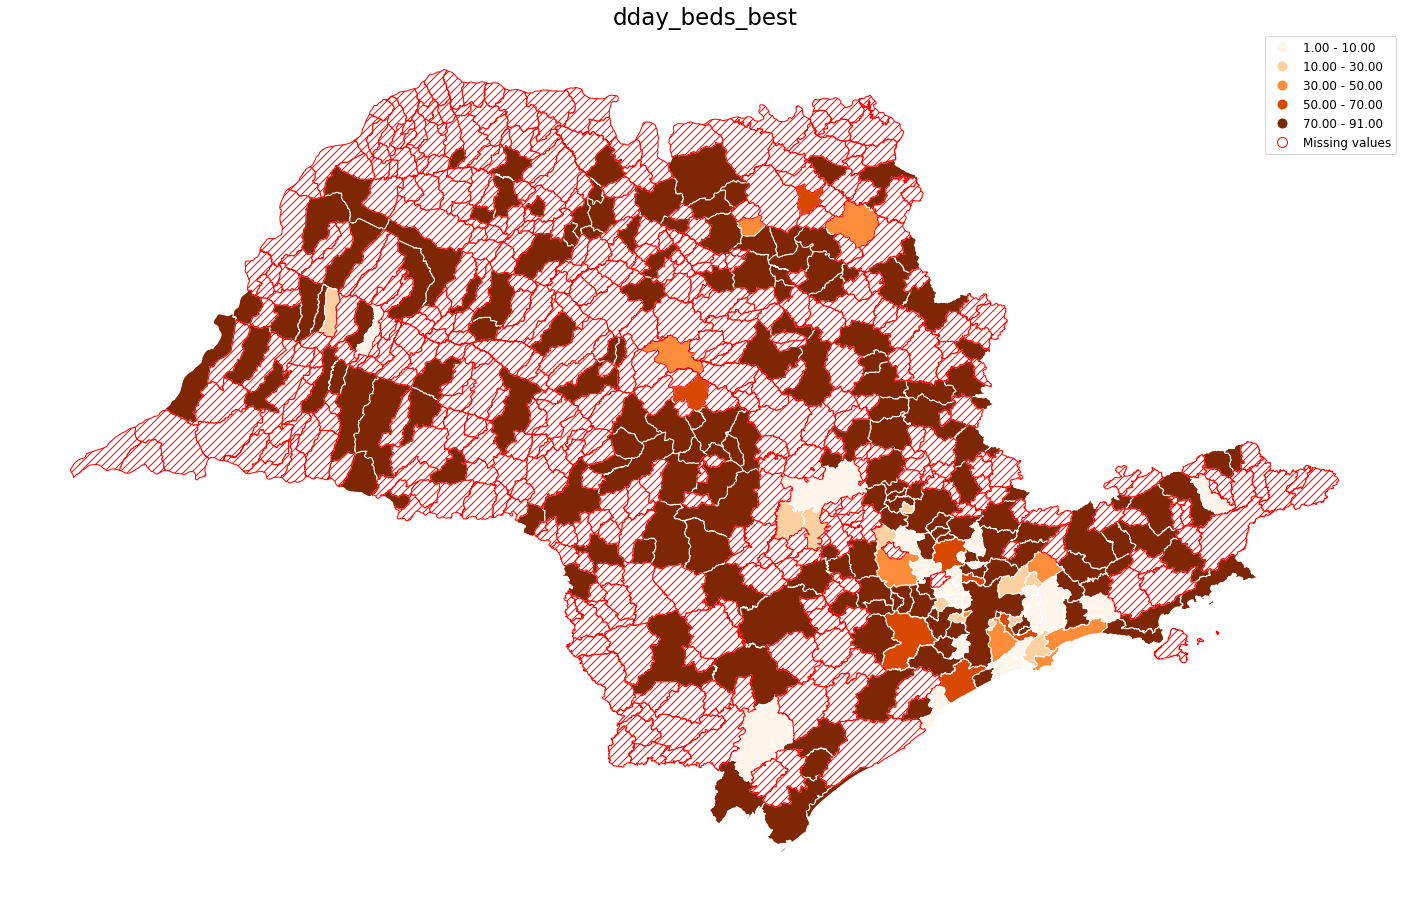

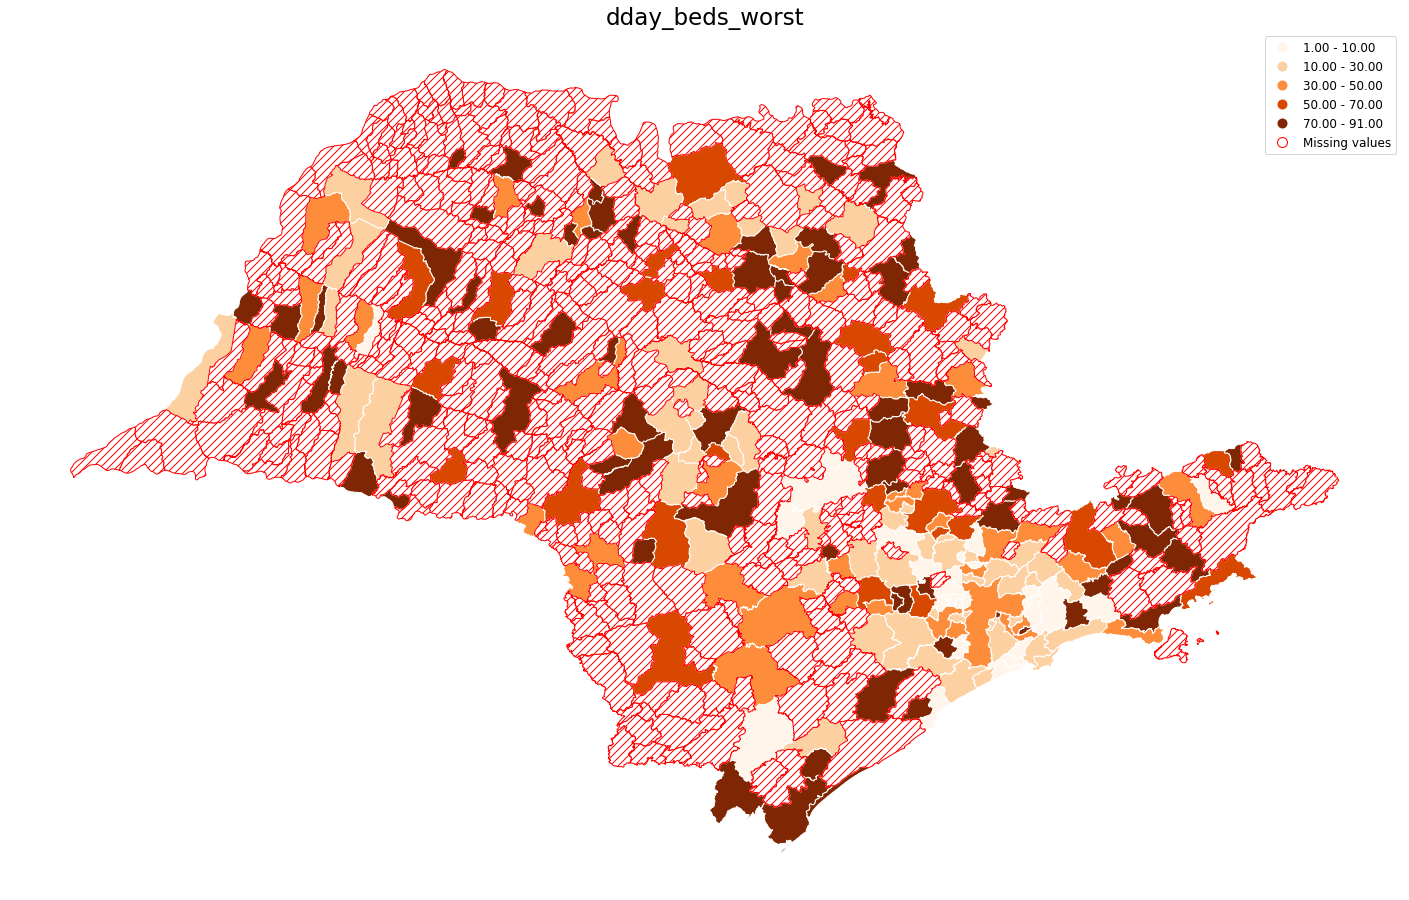

In [117]:
var = 'dday_beds_best'

plot_map(dd,var)


var = 'dday_beds_worst'

plot_map(dd,var)



# var = 'rt_10days_ago_avg'

# plot_map(dd,var)

# var = 'rt_ratio_week_avg'

# plot_map(dd,var)